In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../input/cats-faces-64x64-for-generative-models/'

In [3]:
print(os.listdir(DATA_DIR))

['cats']


In [4]:
print(os.listdir(DATA_DIR+'/cats')[:10])

['7981.jpg', '12666.jpg', '13288.jpg', '6234.jpg', '1269.jpg', '3863.jpg', '6241.jpg', '10304.jpg', '623.jpg', '2193.jpg']


In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

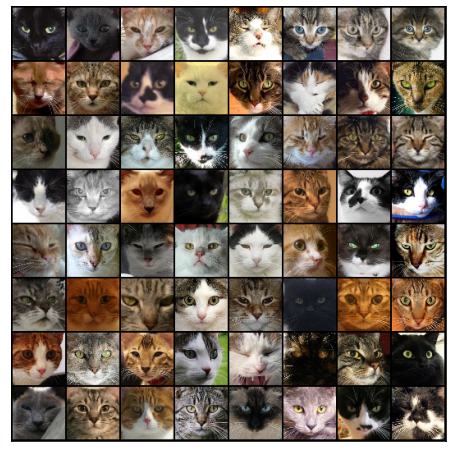

In [8]:
show_batch(train_dl)

In [9]:
!pip install jovian --upgrade --quiet

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


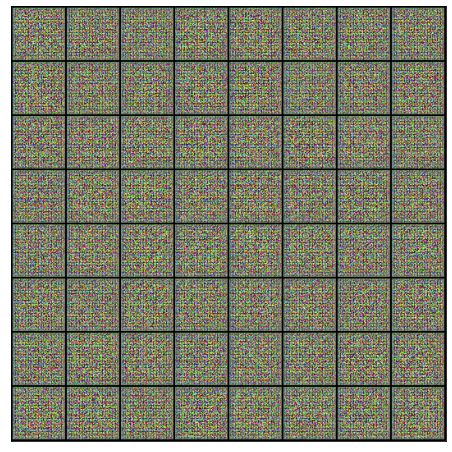

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


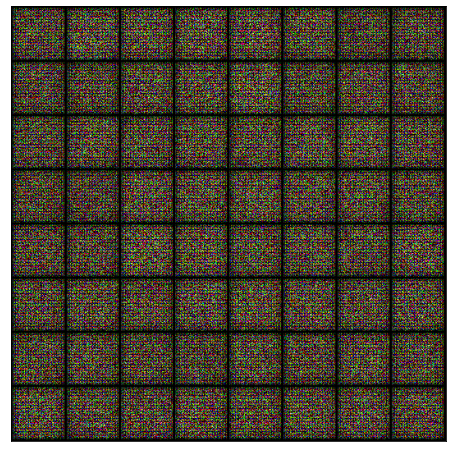

In [24]:
save_samples(0, fixed_latent)

In [25]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [26]:
lr = 0.0002
epochs = 60

In [27]:
history = fit(epochs, lr)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 4.0928, loss_d: 0.5465, real_score: 0.9709, fake_score: 0.3594
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 2.4934, loss_d: 1.0707, real_score: 0.5431, fake_score: 0.2585
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 5.1387, loss_d: 0.8254, real_score: 0.9306, fake_score: 0.4800
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 6.1498, loss_d: 0.8865, real_score: 0.5101, fake_score: 0.0056
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 0.4518, loss_d: 1.5968, real_score: 0.2290, fake_score: 0.0686
Saving generated-images-0005.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 5.3776, loss_d: 0.6679, real_score: 0.9080, fake_score: 0.4111
Saving generated-images-0006.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 5.6303, loss_d: 0.3338, real_score: 0.7644, fake_score: 0.0319
Saving generated-images-0007.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.9227, loss_d: 1.0244, real_score: 0.9940, fake_score: 0.5733
Saving generated-images-0008.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 3.4807, loss_d: 0.4622, real_score: 0.7045, fake_score: 0.0364
Saving generated-images-0009.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 5.5737, loss_d: 0.5118, real_score: 0.9782, fake_score: 0.3530
Saving generated-images-0010.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 3.5743, loss_d: 0.0768, real_score: 0.9532, fake_score: 0.0277
Saving generated-images-0011.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 4.0365, loss_d: 0.3108, real_score: 0.9749, fake_score: 0.2319
Saving generated-images-0012.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 5.7335, loss_d: 0.1152, real_score: 0.9167, fake_score: 0.0272
Saving generated-images-0013.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 6.7217, loss_d: 0.5345, real_score: 0.9588, fake_score: 0.3494
Saving generated-images-0014.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 5.3654, loss_d: 0.0360, real_score: 0.9851, fake_score: 0.0205
Saving generated-images-0015.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 4.2712, loss_d: 0.2052, real_score: 0.8402, fake_score: 0.0213
Saving generated-images-0016.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 5.8700, loss_d: 0.0968, real_score: 0.9161, fake_score: 0.0029
Saving generated-images-0017.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 4.2678, loss_d: 2.0769, real_score: 0.1413, fake_score: 0.0010
Saving generated-images-0018.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 5.2881, loss_d: 0.2520, real_score: 0.7980, fake_score: 0.0045
Saving generated-images-0019.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 5.5947, loss_d: 0.0297, real_score: 0.9758, fake_score: 0.0047
Saving generated-images-0020.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 4.7266, loss_d: 0.1930, real_score: 0.8616, fake_score: 0.0137
Saving generated-images-0021.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 5.1736, loss_d: 0.3383, real_score: 0.9976, fake_score: 0.2390
Saving generated-images-0022.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.7069, loss_d: 0.1045, real_score: 0.9082, fake_score: 0.0070
Saving generated-images-0023.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 6.9877, loss_d: 0.0097, real_score: 0.9938, fake_score: 0.0034
Saving generated-images-0024.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 7.4846, loss_d: 0.0332, real_score: 0.9690, fake_score: 0.0012
Saving generated-images-0025.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 2.2542, loss_d: 0.4711, real_score: 0.7435, fake_score: 0.0704
Saving generated-images-0026.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 11.5221, loss_d: 0.0196, real_score: 0.9809, fake_score: 0.0001
Saving generated-images-0027.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 11.0051, loss_d: 0.6385, real_score: 0.9690, fake_score: 0.4029
Saving generated-images-0028.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 4.1033, loss_d: 0.1039, real_score: 0.9427, fake_score: 0.0419
Saving generated-images-0029.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 5.4272, loss_d: 0.1270, real_score: 0.8885, fake_score: 0.0031
Saving generated-images-0030.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 9.3779, loss_d: 0.0789, real_score: 0.9253, fake_score: 0.0003
Saving generated-images-0031.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 7.2308, loss_d: 0.3509, real_score: 0.9988, fake_score: 0.2261
Saving generated-images-0032.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 3.8369, loss_d: 0.9663, real_score: 0.4242, fake_score: 0.0020
Saving generated-images-0033.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 5.1829, loss_d: 0.1450, real_score: 0.9815, fake_score: 0.1105
Saving generated-images-0034.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 9.8878, loss_d: 0.1232, real_score: 0.8939, fake_score: 0.0002
Saving generated-images-0035.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 1.6896, loss_d: 0.7770, real_score: 0.4895, fake_score: 0.0015
Saving generated-images-0036.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 3.8786, loss_d: 2.3015, real_score: 0.2074, fake_score: 0.0000
Saving generated-images-0037.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 4.3251, loss_d: 0.0553, real_score: 0.9567, fake_score: 0.0099
Saving generated-images-0038.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 6.8145, loss_d: 0.0392, real_score: 0.9752, fake_score: 0.0123
Saving generated-images-0039.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 0.9614, loss_d: 0.4536, real_score: 0.7273, fake_score: 0.0947
Saving generated-images-0040.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 4.3234, loss_d: 0.0236, real_score: 0.9962, fake_score: 0.0190
Saving generated-images-0041.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 3.2042, loss_d: 0.2853, real_score: 0.7799, fake_score: 0.0120
Saving generated-images-0042.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 8.1827, loss_d: 0.1516, real_score: 0.8645, fake_score: 0.0004
Saving generated-images-0043.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 5.1197, loss_d: 0.0331, real_score: 0.9802, fake_score: 0.0127
Saving generated-images-0044.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 9.2263, loss_d: 0.0572, real_score: 0.9508, fake_score: 0.0015
Saving generated-images-0045.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 4.4507, loss_d: 0.0292, real_score: 0.9872, fake_score: 0.0156
Saving generated-images-0046.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 6.4207, loss_d: 0.0094, real_score: 0.9993, fake_score: 0.0084
Saving generated-images-0047.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 4.8839, loss_d: 0.0267, real_score: 0.9980, fake_score: 0.0239
Saving generated-images-0048.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.0542, loss_d: 0.1338, real_score: 0.9064, fake_score: 0.0246
Saving generated-images-0049.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 6.0470, loss_d: 0.1150, real_score: 0.9988, fake_score: 0.0909
Saving generated-images-0050.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 9.5702, loss_d: 0.0107, real_score: 0.9901, fake_score: 0.0007
Saving generated-images-0051.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 8.1289, loss_d: 0.0062, real_score: 0.9966, fake_score: 0.0028
Saving generated-images-0052.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 9.9829, loss_d: 0.4877, real_score: 0.9700, fake_score: 0.3147
Saving generated-images-0053.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 4.8691, loss_d: 0.5126, real_score: 0.7982, fake_score: 0.2094
Saving generated-images-0054.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 7.7801, loss_d: 0.0015, real_score: 0.9994, fake_score: 0.0008
Saving generated-images-0055.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 0.3012, loss_d: 1.2908, real_score: 0.3822, fake_score: 0.0014
Saving generated-images-0056.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 10.6548, loss_d: 0.5772, real_score: 0.9861, fake_score: 0.2722
Saving generated-images-0057.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 8.2574, loss_d: 0.0027, real_score: 0.9980, fake_score: 0.0006
Saving generated-images-0058.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 4.4390, loss_d: 0.0852, real_score: 0.9763, fake_score: 0.0562
Saving generated-images-0059.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 5.9923, loss_d: 0.0537, real_score: 0.9803, fake_score: 0.0242
Saving generated-images-0060.png


In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [29]:
from IPython.display import Image

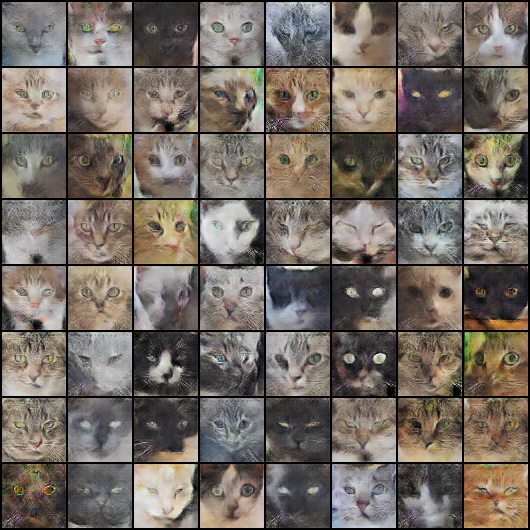

In [30]:
Image('./generated/generated-images-0060.png')

In [31]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


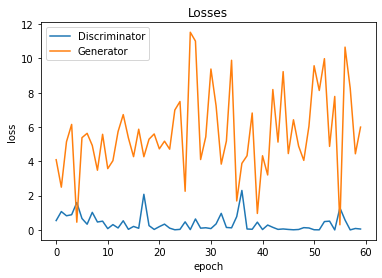

In [32]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

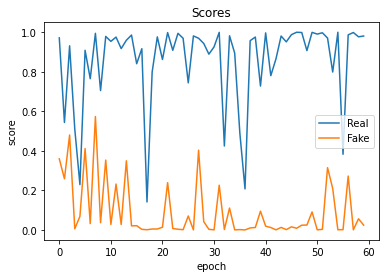

In [33]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');